In [74]:
import numpy as np
import gensim, logging
import csv, string
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import pandas as pd
import tensorflow as tf
import os
import pickle

num_words = 75
num_words_description = 75
directory_prefix = "./"
label_depth = 3
import random
#import gensim.downloader as api
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import remove_stopwords

wv = gensim.models.KeyedVectors.load(directory_prefix+"patents.wv", mmap='r+')
#wv = api.load("glove-wiki-gigaword-50")

porter = PorterStemmer()
embedding_dim = 1000

placeholder_vec = [0 for _ in range(embedding_dim)]

def get_sentence_vector(sentence, num_words):
    ret = []
    sentence = word_tokenize(remove_stopwords(sentence))
    sentence = map(lambda w: porter.stem(w.lower()), sentence)  
    sentence = filter(lambda w: len(w) > 2, sentence)  
    #print(list(sentence))
    for word in sentence:
        try:
            ret.append(wv[word])
        except:
            pass
    #print(len(ret))

    while len(ret) < num_words:
        ret.append(placeholder_vec)

    return np.vstack(ret[:num_words])

import tensorflow_hub as hub

#embed = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1")
#embed = hub.load("https://tfhub.dev/google/Wiki-words-500/2")
embed = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1")

embeddings = embed(["cat is on the mat", "dog is in the fog"])
embedding_dim = embeddings.shape[1]
#print(embeddings)
def get_sentence_vector(words, num_words):
    words = word_tokenize(remove_stopwords(words))
    words = filter(lambda w: len(w)>2, words)
    words = list(filter(lambda w: ~w.isdigit(), words))
    #print(words)
    ret = embed(words)
    ret = tf.pad(ret, tf.constant([[0, max(0, num_words-ret.shape[0]),], [0, 0]]), "CONSTANT")
    ret = ret[:num_words]
    #print(ret)
    return ret
 
with open(directory_prefix+"/class_descriptions_from_patents.pickle", 'rb') as f:
    label_dict = pickle.load(f)
label_dict = {k[:label_depth]: get_sentence_vector(val.lower(), num_words_description) for k, val in label_dict.items()}
#label_dict = {k[:label_depth]: get_sentence_vector(val.lower(), num_words_description) for k, val in label_dict.items()}

label_dict_keys = set(label_dict.keys())


In [107]:
print(label_dict["A01"].shape)

(75, 128)


In [96]:
def lstm_data_generator():
    current_dataframe = pd.read_csv(directory_prefix+'/dataset.csv',sep=',', header = None).to_numpy()#, chunksize=100000)
    indices = np.random.choice(300000, 250000)
    for row in current_dataframe[indices]:
        label, description=row[0], row[1]
        lstm_input_patent = get_sentence_vector(description.lower(), num_words)
        label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
        label_vectors = set([i for i in label_vectors if i in label_dict_keys])
        non_true_vectors = [label_dict[i] for i in random.sample(label_dict_keys, min(2*len(label_vectors), len(label_dict.keys()))) if i not in label_vectors]
        for l in (label_dict[i] for i in label_vectors):
            yield ({'input_1':lstm_input_patent, 'input_2':l}, {'output_binary':[1]})
        for l in non_true_vectors:
            yield ({'input_1':lstm_input_patent, 'input_2':l}, {'output_binary':[0]})

lstm_dataset = tf.data.Dataset.from_generator(lstm_data_generator, ({'input_1':tf.float64, 'input_2':tf.float64}, {'output_binary':tf.float64}), ({'input_1':tf.TensorShape([num_words, embedding_dim]), 'input_2':tf.TensorShape([num_words_description, embedding_dim])}, {'output_binary':tf.TensorShape([1])}))
lstm_dataset = lstm_dataset.batch(16, drop_remainder=True).prefetch(1000).repeat()
           

In [106]:


input_lstm = tf.keras.Input(shape=(num_words, embedding_dim), name='input_1')
input_label = tf.keras.Input(shape=(num_words_description, embedding_dim), name='input_2')

patent = tf.keras.layers.Masking(mask_value=0., input_shape=(num_words, embedding_dim))(input_lstm)
label = tf.keras.layers.Masking(mask_value=0., input_shape=(num_words_description, embedding_dim))(input_label)

layer_size = embedding_dim*2
patent = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True))(patent)
label = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True))(label)


patent = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(layer_size//2))(patent)
patent = tf.keras.layers.GlobalAveragePooling1D()(patent)

label = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(layer_size//2))(label)
label = tf.keras.layers.GlobalAveragePooling1D()(label)
#patent = tf.keras.layers.Dense(layer_size//2)(patent)
#label =  tf.keras.layers.Dense(layer_size//2)(label)

#subtract = tf.keras.layers.Subtract()([patent, label])
#multiply = tf.keras.layers.Multiply()([patent, label])

concat = tf.keras.layers.Concatenate(axis=1)([label, patent])
dense = tf.keras.layers.Dense(int(layer_size))(concat)
dense = tf.keras.layers.Dense(int(layer_size))(dense)
dense = tf.keras.layers.Dense(int(layer_size), activation='relu')(dense)

output_binary = tf.keras.layers.Dense(1, name='output_binary')(dense)


#lstm_enforce_1 = tf.keras.layers.Dense(200, activation='relu')(patent_lstm)
#lstm_enforce_2 = tf.keras.layers.Dense(1000, name='output_2')(lstm_enforce_1)
#model = tf.keras.Model(inputs={'input_1':input_lstm, 'input_2':input_label}, outputs={'output_1':output_binary, 'output_2':lstm_enforce_2})
model = tf.keras.Model(inputs={'input_1':input_lstm, 'input_2':input_label}, outputs=[output_binary])
print(model)

In [92]:
print(len(label_dict))

131


In [108]:
#saver = tf.train.Saver(max_to_keep=4, keep_checkpoint_every_n_hours=2)
#del model
try:
    model.load_weights(directory_prefix+"/doublelstmcheckpoint2.h5")
except:
    pass

model.summary()
opt = tf.optimizers.SGD(lr=0.01, nesterov=True)
model.compile(loss=['mse'],
              optimizer=opt,
              metrics=['accuracy'], experimental_run_tf_function=False)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=directory_prefix+"/doublelstmcheckpoint1.h5",
                                                 save_weights_only=False,
                                                 verbose=1)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        generate_prc()
prc_callback = CustomCallback()

Model: "functional_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 128)]    0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 75, 128)]    0                                            
__________________________________________________________________________________________________
masking_29 (Masking)            (None, 75, 128)      0           input_2[0][0]                    
__________________________________________________________________________________________________
masking_28 (Masking)            (None, 75, 128)      0           input_1[0][0]                    
______________________________________________________________________________________

In [94]:
def generate_prc():
    label_len = len(label_dict_keys)
    #print(label_len)
    left = [label_dict[i] for i in label_dict_keys]
    predictions = []
    left_vectors = np.array(list(label_dict.keys()))
    label_vectors_vector = []
    num_tests = 1000
    def cur_gen():
        for row in pd.read_csv(directory_prefix+'test_dataset.csv',sep=',', header = None).to_numpy():
            label, description=row[0], row[1]
            label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
            label_vectors = set([i for i in label_vectors if i in label_dict_keys])
            if label_vectors == set():
                continue
            label_vectors_vector.append(label_vectors)
            lstm_input_patent =  get_sentence_vector(description.lower(), num_words)
            for i in left:
                yield ({'input_1':lstm_input_patent, 'input_2':i})

    dataset = tf.data.Dataset.from_generator(cur_gen, ({'input_1':tf.float64, 'input_2':tf.float64}), ({'input_1':tf.TensorShape([num_words, embedding_dim]), 'input_2':tf.TensorShape([num_words_description, embedding_dim])}))
    dataset = dataset.batch(label_len).prefetch(50)
    predictions = model.predict(dataset, steps=num_tests, verbose=1).reshape(num_tests, label_len)
    n = 0
    d=0
    ns = []
    recalls = np.arange(0, 1.01, .01)
    ns = []
    
    for prediction, label_vectors in zip(predictions, label_vectors_vector):
        indices = np.flip(np.argsort(prediction, axis=0))
        #print(indices)
        e = [1 if i in label_vectors else 0 for i in left_vectors[indices]]
        cur = []
        total_ones = e.count(1)
        n = 0
        ones_seen = 0
        while ones_seen < total_ones:
            if e[n] == 1:
                ones_seen = ones_seen+1
            n = n+1
            cur.append((ones_seen/float(n), ones_seen/float(total_ones)))
        new_cur = []
        for r in recalls:
            max_of_larger = max([i[0] for i in cur if i[1] >= r])
            new_cur.append(max_of_larger)
        ns.append(new_cur)
        #print(max(new_cur))
        d = d+1
        #print(float(d)/7215)
        #print(np.mean(np.vstack(ns), axis=0)[0])
    p = np.mean(np.array(ns), axis=0)
    np.save("newest_ps.npy", p)
    np.save("predictions.npy", predictions)
    np.save("label_vectors_vector.npy", label_vectors_vector)
    import matplotlib.pyplot as plt
    plt.plot(recalls, p)
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.margins(0.1)
    #plt.xticks(range(len(distribution_dict.keys()))[::50], new_x[::50], rotation='vertical')
    plt.ylabel('Precision', fontsize=16)
    plt.xlabel('Recall', fontsize=16)
    plt.tight_layout()
    plt.show()
    #print(p) 
    plt.savefig('binary_prc1.eps', format='eps')

Epoch 1/100
2998/3000 [============================>.] - ETA: 0s - loss: 0.1716 - accuracy: 0.7584
Epoch 00001: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 43s 43ms/step


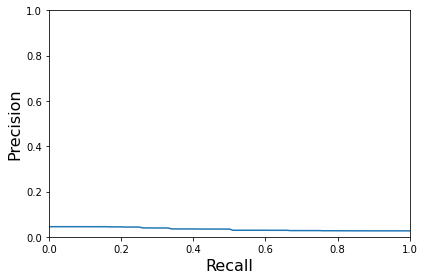

3000/3000 [==============================] - 117s 39ms/step - loss: 0.1716 - accuracy: 0.7584
Epoch 2/100
2998/3000 [============================>.] - ETA: 0s - loss: 0.1491 - accuracy: 0.7872
Epoch 00002: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 35s 35ms/step


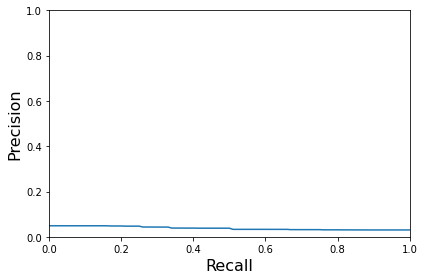

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1491 - accuracy: 0.7872
Epoch 3/100
2998/3000 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.7918
Epoch 00003: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 36s 36ms/step


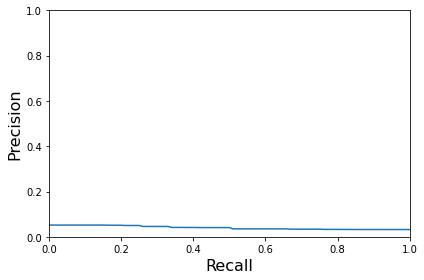

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1453 - accuracy: 0.7919
Epoch 4/100
2998/3000 [============================>.] - ETA: 0s - loss: 0.1422 - accuracy: 0.7951
Epoch 00004: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 35s 35ms/step


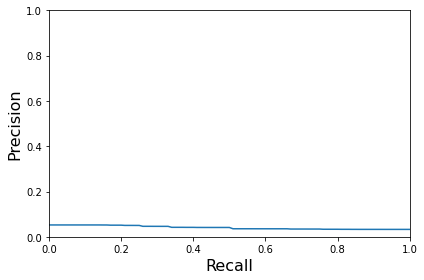

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1421 - accuracy: 0.7952
Epoch 5/100
3000/3000 [==============================] - ETA: 0s - loss: 0.1389 - accuracy: 0.7997
Epoch 00005: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 36s 36ms/step


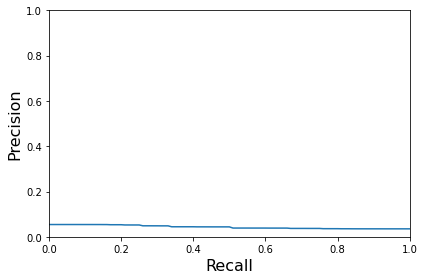

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1389 - accuracy: 0.7997
Epoch 6/100
2999/3000 [============================>.] - ETA: 0s - loss: 0.1357 - accuracy: 0.8074
Epoch 00006: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 36s 36ms/step


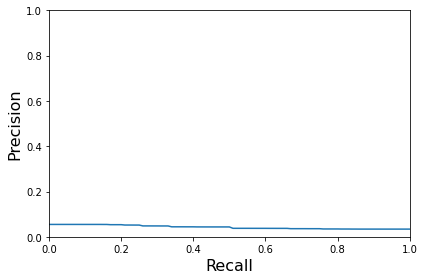

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1358 - accuracy: 0.8073
Epoch 7/100
3000/3000 [==============================] - ETA: 0s - loss: 0.1313 - accuracy: 0.8146
Epoch 00007: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 36s 36ms/step


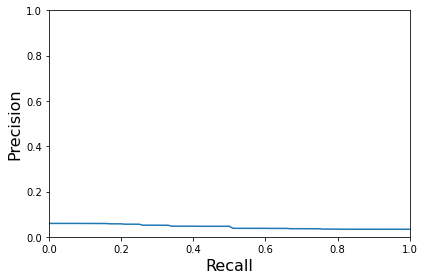

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1313 - accuracy: 0.8146
Epoch 8/100
3000/3000 [==============================] - ETA: 0s - loss: 0.1284 - accuracy: 0.8195
Epoch 00008: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 36s 36ms/step


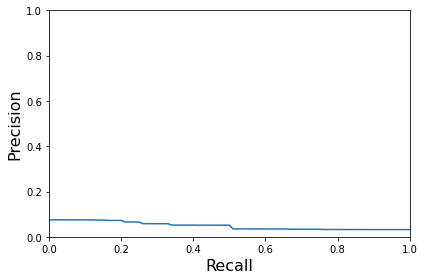

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1284 - accuracy: 0.8195
Epoch 9/100
3000/3000 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.8230
Epoch 00009: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 36s 36ms/step


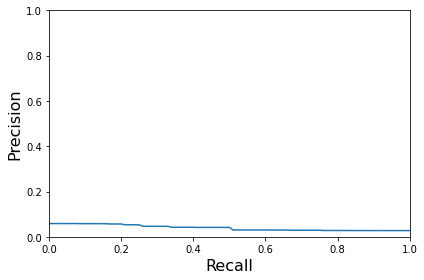

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1259 - accuracy: 0.8230
Epoch 10/100
3000/3000 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.8280
Epoch 00010: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 36s 36ms/step


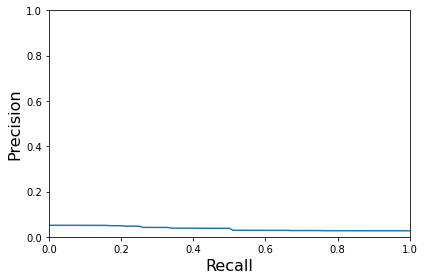

3000/3000 [==============================] - 104s 35ms/step - loss: 0.1207 - accuracy: 0.8311
Epoch 12/100
2999/3000 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.8324
Epoch 00012: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 35s 35ms/step


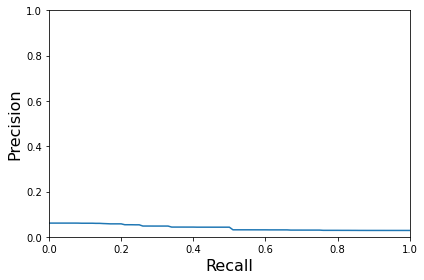

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1197 - accuracy: 0.8324
Epoch 13/100
2999/3000 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.8307
Epoch 00013: saving model to ./doublelstmcheckpoint1.h5
 651/1000 [==================>...........] - ETA: 12s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2998/3000 [============================>.] - ETA: 0s - loss: 0.1162 - accuracy: 0.8361
Epoch 00021: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 36s 36ms/step


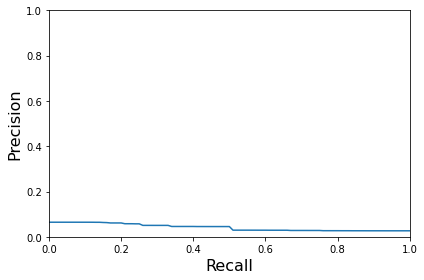

3000/3000 [==============================] - 104s 35ms/step - loss: 0.1161 - accuracy: 0.8362
Epoch 22/100
2999/3000 [============================>.] - ETA: 0s - loss: 0.1121 - accuracy: 0.8419
Epoch 00022: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 36s 36ms/step


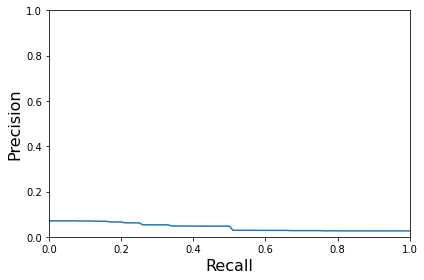

3000/3000 [==============================] - 104s 35ms/step - loss: 0.1121 - accuracy: 0.8419
Epoch 23/100
 852/3000 [=======>......................] - ETA: 47s - loss: 0.1120 - accuracy: 0.8455

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3000/3000 [==============================] - ETA: 0s - loss: 0.1095 - accuracy: 0.8474
Epoch 00030: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 36s 36ms/step


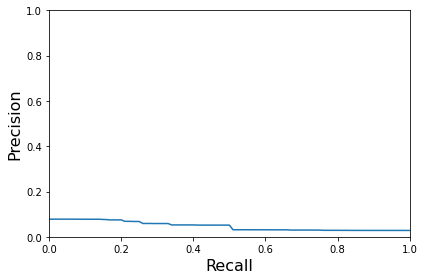

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1095 - accuracy: 0.8474
Epoch 31/100
2998/3000 [============================>.] - ETA: 0s - loss: 0.1094 - accuracy: 0.8456
Epoch 00031: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 35s 35ms/step


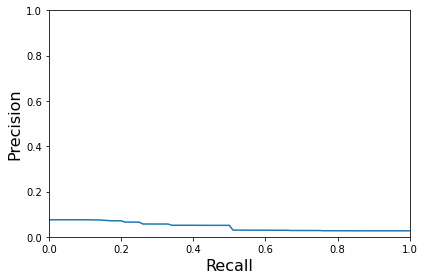

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1094 - accuracy: 0.8457
Epoch 32/100
  97/3000 [..............................] - ETA: 1:03 - loss: 0.1093 - accuracy: 0.8479

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2998/3000 [============================>.] - ETA: 0s - loss: 0.1064 - accuracy: 0.8513
Epoch 00039: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 36s 36ms/step


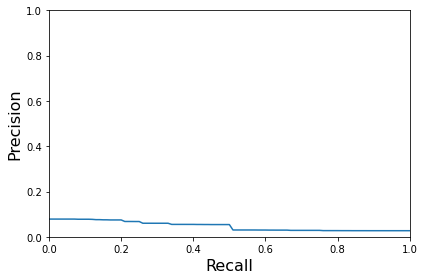

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1064 - accuracy: 0.8513
Epoch 40/100
3000/3000 [==============================] - ETA: 0s - loss: 0.1062 - accuracy: 0.8518
Epoch 00040: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 44s 44ms/step


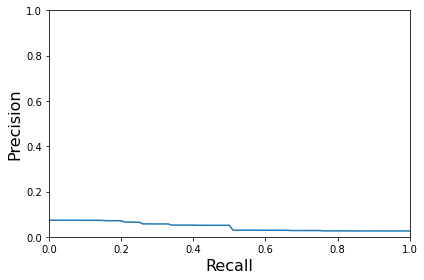

3000/3000 [==============================] - 111s 37ms/step - loss: 0.1062 - accuracy: 0.8518
Epoch 41/100
 850/3000 [=======>......................] - ETA: 47s - loss: 0.1047 - accuracy: 0.8556

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3000/3000 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.8578
Epoch 00048: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 35s 35ms/step


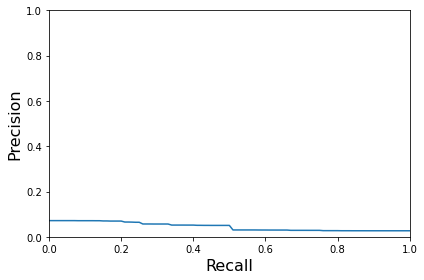

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1021 - accuracy: 0.8578
Epoch 49/100
2999/3000 [============================>.] - ETA: 0s - loss: 0.1036 - accuracy: 0.8566
Epoch 00049: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 35s 35ms/step


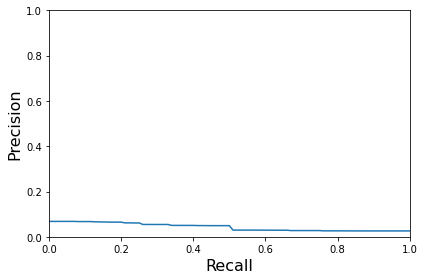

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1036 - accuracy: 0.8566
Epoch 50/100
1950/3000 [==================>...........] - ETA: 23s - loss: 0.1031 - accuracy: 0.8566

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2998/3000 [============================>.] - ETA: 0s - loss: 0.1023 - accuracy: 0.8576
Epoch 00057: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 35s 35ms/step


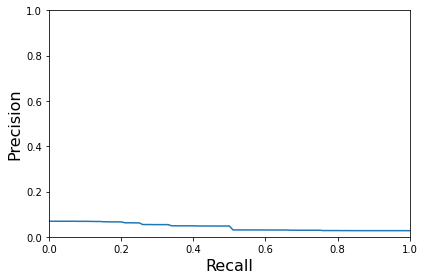

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1023 - accuracy: 0.8576
Epoch 58/100
2998/3000 [============================>.] - ETA: 0s - loss: 0.1006 - accuracy: 0.8621
Epoch 00058: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 36s 36ms/step


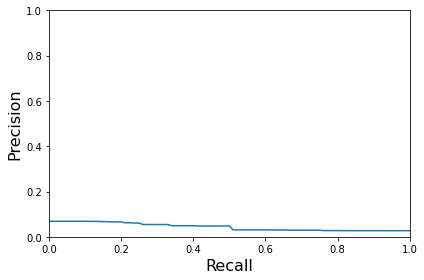

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1006 - accuracy: 0.8622
Epoch 59/100
 831/3000 [=======>......................] - ETA: 48s - loss: 0.1002 - accuracy: 0.8618

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2998/3000 [============================>.] - ETA: 0s - loss: 0.1025 - accuracy: 0.8570
Epoch 00066: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 36s 36ms/step


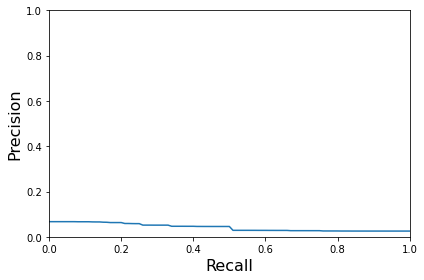

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1025 - accuracy: 0.8570
Epoch 67/100
2998/3000 [============================>.] - ETA: 0s - loss: 0.1021 - accuracy: 0.8581
Epoch 00067: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 36s 36ms/step


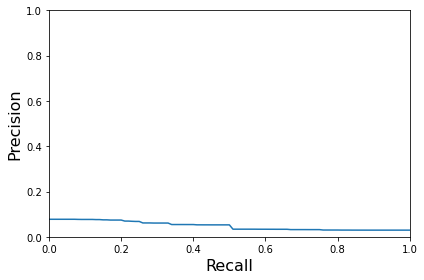

3000/3000 [==============================] - 104s 35ms/step - loss: 0.1021 - accuracy: 0.8581
Epoch 68/100
1903/3000 [==================>...........] - ETA: 24s - loss: 0.1002 - accuracy: 0.8609

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 36s 36ms/step


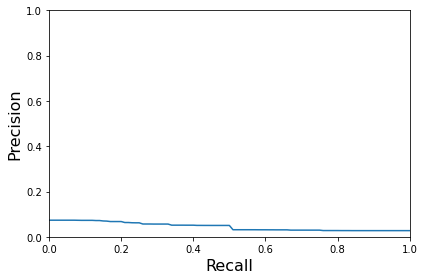

3000/3000 [==============================] - 103s 34ms/step - loss: 0.0979 - accuracy: 0.8653
Epoch 76/100
2998/3000 [============================>.] - ETA: 0s - loss: 0.0994 - accuracy: 0.8635
Epoch 00076: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 36s 36ms/step


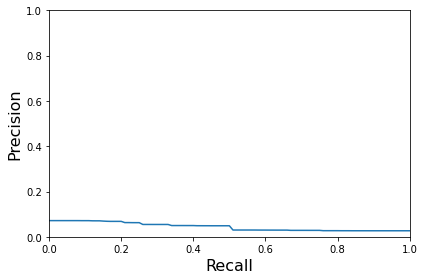

3000/3000 [==============================] - 104s 35ms/step - loss: 0.0995 - accuracy: 0.8634
Epoch 77/100
2883/3000 [===========================>..] - ETA: 2s - loss: 0.0978 - accuracy: 0.8659

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2998/3000 [============================>.] - ETA: 0s - loss: 0.0977 - accuracy: 0.8660
Epoch 00084: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 35s 35ms/step


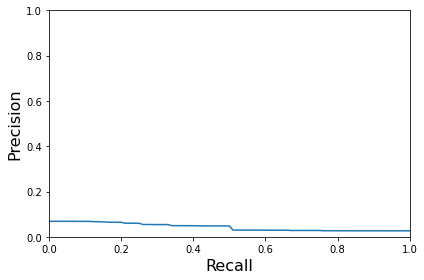

3000/3000 [==============================] - 103s 34ms/step - loss: 0.0977 - accuracy: 0.8660
Epoch 85/100
2999/3000 [============================>.] - ETA: 0s - loss: 0.1000 - accuracy: 0.8622
Epoch 00085: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 35s 35ms/step


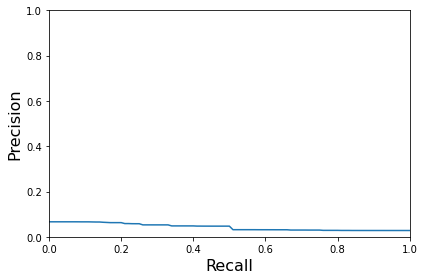

3000/3000 [==============================] - 103s 34ms/step - loss: 0.1000 - accuracy: 0.8622
Epoch 86/100
 382/3000 [==>...........................] - ETA: 57s - loss: 0.0946 - accuracy: 0.8701

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2998/3000 [============================>.] - ETA: 0s - loss: 0.0976 - accuracy: 0.8646
Epoch 00093: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 36s 36ms/step


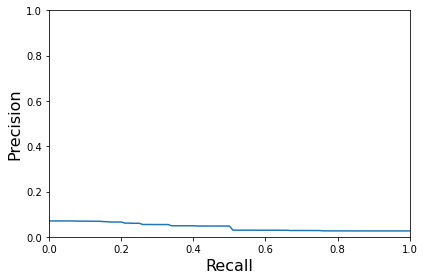

3000/3000 [==============================] - 104s 35ms/step - loss: 0.0977 - accuracy: 0.8645
Epoch 94/100
3000/3000 [==============================] - ETA: 0s - loss: 0.0982 - accuracy: 0.8640
Epoch 00094: saving model to ./doublelstmcheckpoint1.h5
1000/1000 [==============================] - 35s 35ms/step


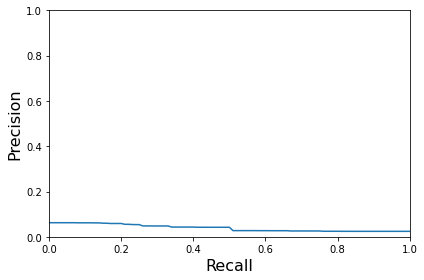

3000/3000 [==============================] - 103s 34ms/step - loss: 0.0982 - accuracy: 0.8640
Epoch 95/100
1171/3000 [==========>...................] - ETA: 40s - loss: 0.0992 - accuracy: 0.8626

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [102]:
history = model.fit(lstm_dataset, epochs=100, steps_per_epoch=3000, callbacks=[cp_callback, prc_callback])

1000/1000 [==============================] - 34s 34ms/step


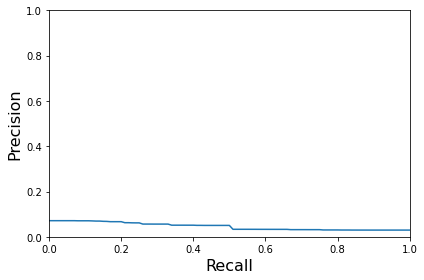

<Figure size 432x288 with 0 Axes>

In [103]:

generate_prc()